In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, Dierckx

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184
┌ Warning: Package PerlaTonettiWaugh does not have NLopt in its dependencies:
│ - If you have PerlaTonettiWaugh checked out for development and have
│   added NLopt as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PerlaTonettiWaugh
└ Loading NLopt into PerlaTonettiWaugh from project dependency, future warnings for PerlaTonettiWaugh are suppressed.


Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 5.0
M = 200
z_grid = range(z_min, stop = z_max, length = M) # Since we only care about the grid. 

# Define common objects. 
d_0 = 5
d_T = 2.3701
params = (ρ = 0.02, σ = 4.2508, N = 10, θ = 5.1269, γ = 1.00, κ = 0.013, ζ = 1, η = 0, Theta = 1, χ = 1/(2.1868), υ = 0.0593, μ = 0, δ = 0.053) # Baselines per Jesse. 
δ = params.δ
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T

stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

println("g = $(stationary_sol.g), z_hat = $(stationary_sol.z_hat), Ω = $(stationary_sol.Ω)")

g = 0.02389665244308684, z_hat = 1.3951350964853995, Ω = 0.9536180359512142


Define the objective function:

In [4]:
function solve_with_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = CubicSplineInterpolation(ts, E_hat_vec_scaled) # might worth trying cubic spline
    E_hat(t) = E_hat_interpolation(t)

    M = log(Ω_T/Ω_0) / quadgk(E_hat, 0, T)[1]
    Ω_derivative(Ω,p,t) = M*E_hat(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω(t::Float64) = t <= T ? Ω_solution(t) : Ω_solution(T)
    E(t::Float64) = M*E_hat(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    return solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
end

function evaluate_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = Spline1D(ts, E_hat_vec_scaled; k = 3) # cubic spline
    
    M = log(Ω_T/Ω_0) / integrate(E_hat_interpolation, 0, T)
    Ω_derivative(Ω,p,t) = M*E_hat_interpolation(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω = t -> t <= T ? Ω_solution(t) : Ω_solution(T)
    E = t -> M*E_hat_interpolation(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    solved = try solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = false).results catch; return Inf end
    
    t = solved.t
    entry_residual = solved.entry_residual

    # interpolate on returned entry_residual
    entry_residual_interpolated = LinearInterpolation(t, entry_residual)

    # evaluate entry_residual on entry_residual_nodes, return the norm
    entry_residuals_nodes = range(0, stop = T, length = ENTRY_RESIDUALS_NODES_COUNT + 2)
    
    entry_residuals_vector = entry_residual_interpolated.(entry_residuals_nodes[2:(end-1)])
    
    return (sqrt(sum(entry_residuals_vector .* WEIGHTS .* entry_residuals_vector)))
end

evaluate_candidate (generic function with 1 method)

Setup for optimizer:

In [29]:
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
MAX_TIME = 600
RANGES_NODES = map(i->(SOLUTION[i] - 1e-5, SOLUTION[i] + 1e-5), 1:(E_NODE_COUNT-1))
RANGES = [RANGES_NODES; (34.5, 36.0)]
WEIGHTS = fill(1, ENTRY_RESIDUALS_NODES_COUNT)
WEIGHTS = [fill(15, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-3)]
# SOLUTION = [-0.9997956002352905; -0.8044531196727387; -0.6461191850889159; -0.49895463423758685; -0.3139705145516665; -0.29240469253488566; -0.1954115690245979; -0.10918111468996877; -0.099322781569235; -0.0930746966042603; -0.04914486979168577; -0.03044126729299556; -0.015727135530718334; -0.011010217532088591; 34.614583662316235]

15-element Array{Int64,1}:
 15
 15
 15
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1

Find optimal `Ω`:

In [30]:
# result = bboptimize(evaluate_candidate; SearchRange = RANGES, NumDimensions = length(RANGES), MaxTime = MAX_TIME)
# SOLUTION = best_candidate(result)
# result2 = optimize(evaluate_candidate, SOLUTION, BFGS(), Optim.Options(time_limit = MAX_TIME, show_trace = true))
# SOLUTION = result.minimizer

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.56 secs, 11 evals, 6 steps, improv/step: 0.333 (last = 0.3333), fitness=0.003373976
1.11 secs, 22 evals, 12 steps, improv/step: 0.500 (last = 0.6667), fitness=0.002469195
1.62 secs, 30 evals, 17 steps, improv/step: 0.412 (last = 0.2000), fitness=0.002469195
2.14 secs, 41 evals, 23 steps, improv/step: 0.391 (last = 0.3333), fitness=0.002469195
2.73 secs, 53 evals, 29 steps, improv/step: 0.483 (last = 0.8333), fitness=0.002469195
3.30 secs, 65 evals, 35 steps, improv/step: 0.514 (last = 0.6667), fitness=0.002469195
3.88 secs, 77 evals, 41 steps, improv/step: 0.512 (last = 0.5000), fitness=0.002469195
4.40 secs, 88 evals, 48 steps, improv/step: 0.500 (last = 0.4286), fitness=0.002469195
4.98 secs, 100 evals, 56 steps, improv/step: 0.500 (last = 0.5000), fitness=0.002431796
5.48 secs, 110 eval

48.47 secs, 958 evals, 848 steps, improv/step: 0.254 (last = 0.2000), fitness=0.001833777
48.99 secs, 968 evals, 858 steps, improv/step: 0.253 (last = 0.2000), fitness=0.001833777
49.51 secs, 977 evals, 867 steps, improv/step: 0.253 (last = 0.2222), fitness=0.001833777
50.02 secs, 988 evals, 878 steps, improv/step: 0.253 (last = 0.2727), fitness=0.001833777
50.62 secs, 1001 evals, 890 steps, improv/step: 0.253 (last = 0.2500), fitness=0.001833777
51.12 secs, 1012 evals, 900 steps, improv/step: 0.252 (last = 0.2000), fitness=0.001833777
51.63 secs, 1023 evals, 911 steps, improv/step: 0.251 (last = 0.1818), fitness=0.001833777
52.17 secs, 1034 evals, 921 steps, improv/step: 0.249 (last = 0.0000), fitness=0.001833777
52.71 secs, 1045 evals, 932 steps, improv/step: 0.247 (last = 0.0909), fitness=0.001833777
53.24 secs, 1055 evals, 942 steps, improv/step: 0.244 (last = 0.0000), fitness=0.001833777
53.76 secs, 1066 evals, 953 steps, improv/step: 0.242 (last = 0.0909), fitness=0.001833777
54.

95.76 secs, 1926 evals, 1811 steps, improv/step: 0.198 (last = 0.1111), fitness=0.001833777
96.30 secs, 1938 evals, 1823 steps, improv/step: 0.197 (last = 0.0000), fitness=0.001833777
96.83 secs, 1950 evals, 1835 steps, improv/step: 0.196 (last = 0.0833), fitness=0.001833777
97.35 secs, 1961 evals, 1846 steps, improv/step: 0.196 (last = 0.0909), fitness=0.001833777
97.89 secs, 1972 evals, 1857 steps, improv/step: 0.194 (last = 0.0000), fitness=0.001833777
98.40 secs, 1983 evals, 1868 steps, improv/step: 0.194 (last = 0.0909), fitness=0.001833777
98.92 secs, 1994 evals, 1879 steps, improv/step: 0.194 (last = 0.1818), fitness=0.001833777
99.42 secs, 2005 evals, 1890 steps, improv/step: 0.193 (last = 0.0909), fitness=0.001833777
99.95 secs, 2017 evals, 1902 steps, improv/step: 0.192 (last = 0.0833), fitness=0.001833777
100.47 secs, 2028 evals, 1913 steps, improv/step: 0.193 (last = 0.3636), fitness=0.001833777
100.97 secs, 2038 evals, 1923 steps, improv/step: 0.194 (last = 0.4000), fitnes

142.47 secs, 2931 evals, 2816 steps, improv/step: 0.183 (last = 0.0000), fitness=0.001833777
143.01 secs, 2943 evals, 2828 steps, improv/step: 0.182 (last = 0.1667), fitness=0.001833777
143.54 secs, 2955 evals, 2840 steps, improv/step: 0.182 (last = 0.0833), fitness=0.001833777
144.08 secs, 2967 evals, 2852 steps, improv/step: 0.182 (last = 0.0833), fitness=0.001833777
144.60 secs, 2978 evals, 2863 steps, improv/step: 0.181 (last = 0.0909), fitness=0.001833777
145.10 secs, 2989 evals, 2874 steps, improv/step: 0.182 (last = 0.2727), fitness=0.001833777
145.61 secs, 2999 evals, 2885 steps, improv/step: 0.181 (last = 0.0909), fitness=0.001833777
146.14 secs, 3009 evals, 2895 steps, improv/step: 0.181 (last = 0.1000), fitness=0.001833777
146.65 secs, 3019 evals, 2905 steps, improv/step: 0.181 (last = 0.2000), fitness=0.001833777
147.17 secs, 3031 evals, 2917 steps, improv/step: 0.180 (last = 0.0000), fitness=0.001833777
147.72 secs, 3040 evals, 2926 steps, improv/step: 0.180 (last = 0.1111

188.99 secs, 3952 evals, 3838 steps, improv/step: 0.154 (last = 0.0833), fitness=0.001833755
189.51 secs, 3964 evals, 3850 steps, improv/step: 0.154 (last = 0.0833), fitness=0.001833755
190.02 secs, 3975 evals, 3861 steps, improv/step: 0.153 (last = 0.0000), fitness=0.001833755
190.54 secs, 3987 evals, 3873 steps, improv/step: 0.153 (last = 0.0833), fitness=0.001833755
191.08 secs, 3999 evals, 3885 steps, improv/step: 0.153 (last = 0.0833), fitness=0.001833755
191.59 secs, 4009 evals, 3895 steps, improv/step: 0.153 (last = 0.0000), fitness=0.001833755
192.10 secs, 4018 evals, 3904 steps, improv/step: 0.152 (last = 0.0000), fitness=0.001833755
192.64 secs, 4030 evals, 3916 steps, improv/step: 0.152 (last = 0.0833), fitness=0.001833755
193.18 secs, 4042 evals, 3928 steps, improv/step: 0.151 (last = 0.0000), fitness=0.001833755
193.69 secs, 4053 evals, 3939 steps, improv/step: 0.151 (last = 0.0909), fitness=0.001833755
194.21 secs, 4065 evals, 3951 steps, improv/step: 0.151 (last = 0.0000

235.71 secs, 4966 evals, 4852 steps, improv/step: 0.130 (last = 0.0000), fitness=0.001833635
236.23 secs, 4977 evals, 4863 steps, improv/step: 0.129 (last = 0.0000), fitness=0.001833635
236.77 secs, 4989 evals, 4875 steps, improv/step: 0.129 (last = 0.0000), fitness=0.001833635
237.28 secs, 5000 evals, 4886 steps, improv/step: 0.129 (last = 0.0000), fitness=0.001833635
237.82 secs, 5012 evals, 4898 steps, improv/step: 0.128 (last = 0.0000), fitness=0.001833635
238.34 secs, 5023 evals, 4909 steps, improv/step: 0.128 (last = 0.0000), fitness=0.001833635
238.87 secs, 5034 evals, 4920 steps, improv/step: 0.128 (last = 0.0000), fitness=0.001833635
239.44 secs, 5043 evals, 4929 steps, improv/step: 0.128 (last = 0.1111), fitness=0.001833635
239.97 secs, 5052 evals, 4938 steps, improv/step: 0.128 (last = 0.0000), fitness=0.001833635
240.48 secs, 5064 evals, 4950 steps, improv/step: 0.128 (last = 0.1667), fitness=0.001833463
240.99 secs, 5076 evals, 4962 steps, improv/step: 0.128 (last = 0.0833

282.06 secs, 5961 evals, 5847 steps, improv/step: 0.113 (last = 0.0000), fitness=0.001833463
282.60 secs, 5972 evals, 5858 steps, improv/step: 0.112 (last = 0.0000), fitness=0.001833463
283.15 secs, 5982 evals, 5868 steps, improv/step: 0.112 (last = 0.1000), fitness=0.001833463
283.68 secs, 5993 evals, 5879 steps, improv/step: 0.112 (last = 0.0000), fitness=0.001833463
284.22 secs, 6005 evals, 5891 steps, improv/step: 0.112 (last = 0.0000), fitness=0.001833463
284.74 secs, 6016 evals, 5902 steps, improv/step: 0.112 (last = 0.0000), fitness=0.001833463
285.27 secs, 6026 evals, 5912 steps, improv/step: 0.112 (last = 0.2000), fitness=0.001833463
285.80 secs, 6038 evals, 5924 steps, improv/step: 0.112 (last = 0.0000), fitness=0.001833463
286.34 secs, 6050 evals, 5936 steps, improv/step: 0.111 (last = 0.0000), fitness=0.001833463
286.88 secs, 6062 evals, 5948 steps, improv/step: 0.111 (last = 0.0000), fitness=0.001833463
287.41 secs, 6074 evals, 5960 steps, improv/step: 0.111 (last = 0.0000

328.59 secs, 7005 evals, 6891 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
329.11 secs, 7017 evals, 6903 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
329.64 secs, 7029 evals, 6915 steps, improv/step: 0.099 (last = 0.0833), fitness=0.001833463
330.17 secs, 7041 evals, 6927 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
330.71 secs, 7053 evals, 6939 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
331.22 secs, 7065 evals, 6951 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
331.74 secs, 7076 evals, 6962 steps, improv/step: 0.099 (last = 0.0000), fitness=0.001833463
332.25 secs, 7087 evals, 6973 steps, improv/step: 0.098 (last = 0.0000), fitness=0.001833463
332.77 secs, 7099 evals, 6985 steps, improv/step: 0.098 (last = 0.0000), fitness=0.001833463
333.28 secs, 7110 evals, 6996 steps, improv/step: 0.098 (last = 0.0000), fitness=0.001833463
333.82 secs, 7122 evals, 7008 steps, improv/step: 0.098 (last = 0.0833

374.92 secs, 8002 evals, 7889 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
375.42 secs, 8012 evals, 7899 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
375.96 secs, 8023 evals, 7910 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
376.47 secs, 8034 evals, 7921 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
377.01 secs, 8046 evals, 7933 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
377.53 secs, 8057 evals, 7944 steps, improv/step: 0.090 (last = 0.1818), fitness=0.001833463
378.04 secs, 8068 evals, 7955 steps, improv/step: 0.090 (last = 0.0909), fitness=0.001833463
378.58 secs, 8079 evals, 7966 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
379.12 secs, 8090 evals, 7977 steps, improv/step: 0.090 (last = 0.0000), fitness=0.001833463
379.68 secs, 8102 evals, 7989 steps, improv/step: 0.089 (last = 0.0000), fitness=0.001833463
380.22 secs, 8113 evals, 8000 steps, improv/step: 0.089 (last = 0.0909

421.68 secs, 9028 evals, 8915 steps, improv/step: 0.082 (last = 0.0000), fitness=0.001833463
422.18 secs, 9039 evals, 8926 steps, improv/step: 0.082 (last = 0.0909), fitness=0.001833463
422.70 secs, 9050 evals, 8937 steps, improv/step: 0.082 (last = 0.0000), fitness=0.001833463
423.25 secs, 9061 evals, 8948 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
423.77 secs, 9072 evals, 8959 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
424.31 secs, 9083 evals, 8970 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
424.84 secs, 9094 evals, 8981 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
425.37 secs, 9103 evals, 8990 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
425.88 secs, 9114 evals, 9001 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
426.41 secs, 9126 evals, 9013 steps, improv/step: 0.081 (last = 0.0000), fitness=0.001833463
426.93 secs, 9138 evals, 9025 steps, improv/step: 0.081 (last = 0.1667

467.87 secs, 10033 evals, 9921 steps, improv/step: 0.075 (last = 0.0000), fitness=0.001833463
468.40 secs, 10046 evals, 9934 steps, improv/step: 0.075 (last = 0.0000), fitness=0.001833463
468.91 secs, 10058 evals, 9946 steps, improv/step: 0.075 (last = 0.0000), fitness=0.001833463
469.41 secs, 10070 evals, 9958 steps, improv/step: 0.075 (last = 0.0000), fitness=0.001833463
469.92 secs, 10082 evals, 9970 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
470.42 secs, 10094 evals, 9982 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
470.95 secs, 10106 evals, 9994 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
471.47 secs, 10117 evals, 10005 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
472.00 secs, 10129 evals, 10017 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
472.52 secs, 10141 evals, 10029 steps, improv/step: 0.074 (last = 0.0000), fitness=0.001833463
473.05 secs, 10153 evals, 10041 steps, improv/step: 0.074

513.40 secs, 11048 evals, 10936 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
513.94 secs, 11060 evals, 10948 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
514.44 secs, 11072 evals, 10960 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
514.97 secs, 11084 evals, 10972 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
515.48 secs, 11096 evals, 10984 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
516.02 secs, 11108 evals, 10996 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
516.54 secs, 11120 evals, 11008 steps, improv/step: 0.069 (last = 0.0833), fitness=0.001833463
517.08 secs, 11131 evals, 11019 steps, improv/step: 0.069 (last = 0.0000), fitness=0.001833463
517.58 secs, 11142 evals, 11030 steps, improv/step: 0.068 (last = 0.0000), fitness=0.001833463
518.10 secs, 11154 evals, 11042 steps, improv/step: 0.068 (last = 0.0000), fitness=0.001833463
518.65 secs, 11165 evals, 11053 steps, improv/step

559.05 secs, 12050 evals, 11938 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
559.55 secs, 12061 evals, 11949 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
560.08 secs, 12072 evals, 11960 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
560.62 secs, 12084 evals, 11972 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
561.15 secs, 12095 evals, 11983 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
561.66 secs, 12106 evals, 11994 steps, improv/step: 0.064 (last = 0.0909), fitness=0.001833463
562.16 secs, 12117 evals, 12005 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
562.67 secs, 12128 evals, 12016 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
563.21 secs, 12140 evals, 12028 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
563.72 secs, 12151 evals, 12039 steps, improv/step: 0.064 (last = 0.0000), fitness=0.001833463
564.23 secs, 12162 evals, 12050 steps, improv/step

15-element Array{Float64,1}:
 -0.29289795275307035 
 -0.1333308334909441  
 -0.08943073847175766 
 -0.018393504495704625
 -0.0892985213503656  
 -0.9413628431953878  
 -0.4178928412345703  
 -0.5667420376687293  
 -0.017005969264276753
 -0.03568120926177449 
 -0.7468697291201996  
 -0.21670206903613506 
 -0.022712845715108274
 -0.017002985186103957
 35.00140214651399    

Find the corresponding solution

In [141]:
SOLUTION = [-0.29289587818815976; -0.1333218306767743; -0.08942934611931058;  -0.018386019083147458; -0.08930489493014641;  -0.941358463553554;  -0.41788897050932516;  -0.5667354234090646;   -0.01700255640563696;  -0.035690205818277365; -0.7468699888323547;   -0.21670305161145972;  -0.022706851500478447; -0.01700298441332641;  34.99997676121191]    

15-element Array{Float64,1}:
 -0.29289587818815976 
 -0.1333218306767743  
 -0.08942934611931058 
 -0.018386019083147458
 -0.08930489493014641 
 -0.941358463553554   
 -0.41788897050932516 
 -0.5667354234090646  
 -0.01700255640563696 
 -0.035690205818277365
 -0.7468699888323547  
 -0.21670305161145972 
 -0.022706851500478447
 -0.01700298441332641 
 34.99997676121191    

In [142]:
# [-0.9997956002352905; -0.8044531196727387; -0.6461191850889159; -0.49895463423758685; -0.3139705145516665; -0.29240469253488566; -0.1954115690245979; -0.10918111468996877; -0.099322781569235; -0.0930746966042603; -0.04914486979168577; -0.03044126729299556; -0.015727135530718334; -0.011010217532088591; 34.614583662316235]
# gives good solution.
solved = solve_with_candidate(SOLUTION)

v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results;

## Plots for Ω and `entry_residuals`

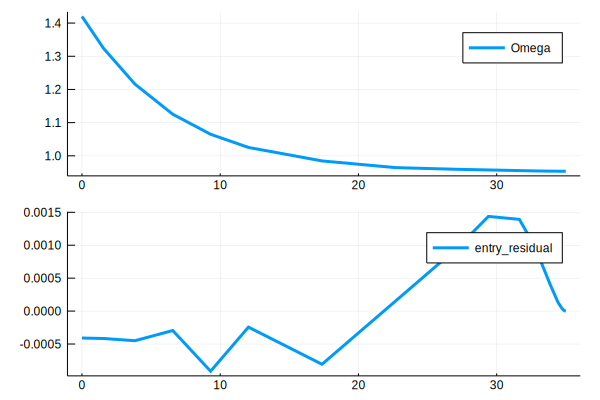

In [143]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

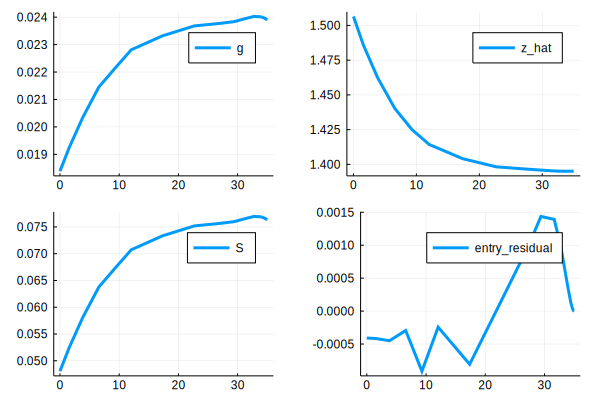

In [144]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

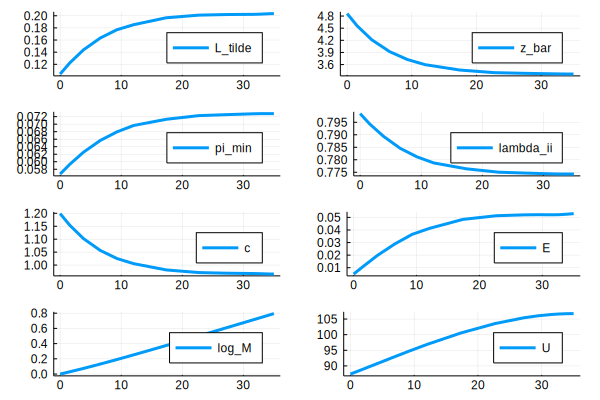

In [145]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

In [16]:
# Can examine the returned data with the Voyager and/or Vegalite
using DataVoyager, VegaLite
solved |> Voyager()
#solved |> @vlplot(:line, x = :t, y = :g, width=400, height=400)

ErrorException: Path contained unexpected character